In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


# Importing relevant packages

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')


# Loading the data

In [3]:
houseprice_train = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv",
                              index_col=0)
houseprice_test = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv",
                             index_col=0)

# Exploratory Data Analysis
## Checking the shape of the data

In [4]:
print(houseprice_train.shape)
print(houseprice_test.shape)

(1460, 80)
(1459, 79)


## Checking out the first few rows

In [5]:
display(houseprice_train.head())

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Checking the data types of different variables

In [6]:
houseprice_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuilt    

In [7]:
proportion_of_na =pd.DataFrame(houseprice_train.isna().sum().sort_values(ascending = False)/
                               len(houseprice_train), columns = ['proportions'])
proportion_of_na = proportion_of_na.reset_index()

proportion_of_na

,index,proportions
0,PoolQC,0.995205
1,MiscFeature,0.963014
2,Alley,0.937671
3,Fence,0.807534
4,MasVnrType,0.597260
...,...,...
75,Heating,0.000000
76,HeatingQC,0.000000
77,MSZoning,0.000000
78,1stFlrSF,0.000000


## Dropping missing values in columns where the proportion of missing values is less than five percent

In [8]:
columns_to_drop_na = []
for row in range(len(proportion_of_na)):
    if proportion_of_na.loc[row, 'proportions'] <= 0.05:
        columns_to_drop_na.append(proportion_of_na.loc[row, 'index'])
houseprice_train = houseprice_train.dropna(subset = columns_to_drop_na)


In [9]:
(houseprice_train.isna().sum()/len(houseprice_train)).sort_values(ascending = False)

PoolQC         0.995042
MiscFeature    0.963881
Alley          0.936969
Fence          0.803824
MasVnrType     0.588527
                 ...   
Foundation     0.000000
ExterCond      0.000000
ExterQual      0.000000
MasVnrArea     0.000000
SalePrice      0.000000
Length: 80, dtype: float64

## Dropping columns with a proportion of more than 50%

In [10]:
proportion_of_na =pd.DataFrame(houseprice_train.isna().sum().sort_values(ascending = False)/
                               len(houseprice_train), columns = ['proportions']).reset_index()
columns_to_drop = []

columns_to_drop = []
for row in range(len(proportion_of_na)):
    if proportion_of_na.loc[row, 'proportions'] > 0.5:
        columns_to_drop.append(proportion_of_na.loc[row, 'index'])
print(columns_to_drop)

['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'MasVnrType']


In [11]:
houseprice_train.drop(columns = columns_to_drop, inplace = True)
(houseprice_train.isna().sum()/len(houseprice_train)).sort_values(ascending = False)

FireplaceQu     0.465297
LotFrontage     0.177762
GarageFinish    0.052408
GarageType      0.052408
GarageQual      0.052408
                  ...   
ExterCond       0.000000
ExterQual       0.000000
MasVnrArea      0.000000
Exterior2nd     0.000000
SalePrice       0.000000
Length: 75, dtype: float64

Next, we will inspect the columns with missing values to know how we can perhaps impute them.
### FireplaceQu

657


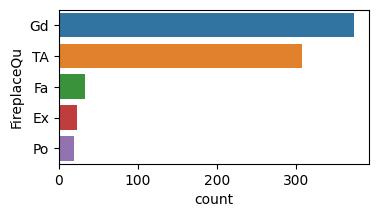

In [12]:
print(houseprice_train['FireplaceQu'].isna().sum())
#visualizing the categories of FireplaceQu
sorted_order = houseprice_train['FireplaceQu'].value_counts().index
plt.figure(figsize = (4,2))
sns.countplot(data = houseprice_train, y = 'FireplaceQu', order = sorted_order)
plt.show()

We can see that GD and TA categories are the most frequent, we will impute missing values randomly using these categories

In [13]:
# Calculating proportions of TA and GD
gd_count = houseprice_train['FireplaceQu'].value_counts().get('Gd', 0)
ta_count = houseprice_train['FireplaceQu'].value_counts().get('TA', 0)
total_count = gd_count + ta_count

gd_prob = gd_count / total_count
ta_prob = ta_count / total_count

def random_impute(value):
    if pd.isna(value):
        return np.random.choice(['Gd', 'TA'], p=[gd_prob, ta_prob])
    else:
        return value
# Imputing
houseprice_train['FireplaceQu'] = houseprice_train['FireplaceQu'].apply(random_impute)
houseprice_train['FireplaceQu'].isna().sum()

0

### LotFrontage

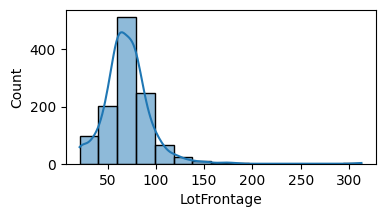

In [14]:
# Visualizing the distribution of LotFrontage
plt.figure(figsize = (4,2))
sns.histplot(data = houseprice_train, x = 'LotFrontage', bins = 15, kde = True)
plt.show()

The `LotFrontge` values appear to be normally distributed. We will therefore do our imputation using the mean.

In [15]:
houseprice_train['LotFrontage'] = houseprice_train['LotFrontage'].fillna(houseprice_train['LotFrontage'].mean)
houseprice_train['LotFrontage'].isna().sum()

0

We will try to have a look at all the remaining columns at once;

GarageFinish object
GarageType object
GarageQual object
GarageCond object
GarageYrBlt float64


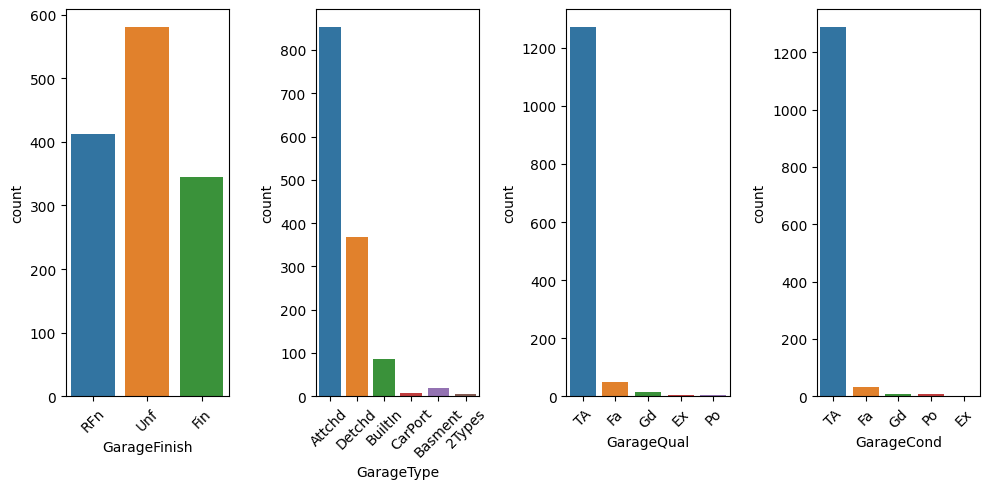

In [16]:
cols_missing = ['GarageFinish','GarageType','GarageQual','GarageCond','GarageYrBlt']
for col in cols_missing:
    print(col, houseprice_train[col].dtype)
fig, ax = plt.subplots(1,4, figsize = (10,5))
sns.countplot(data = houseprice_train, x ='GarageFinish' , ax=ax[0])
sns.countplot(data = houseprice_train, x = 'GarageType', ax = ax[1])
sns.countplot(data = houseprice_train, x = 'GarageQual', ax = ax[2])
sns.countplot(data = houseprice_train, x = 'GarageCond', ax = ax[3])
for axis in ax:
    axis.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()


We will impute `GarageFinish` missing values randomly. As for the other three variables, we will impute them using the mode.

In [17]:
RFn_count = houseprice_train['GarageFinish'].value_counts().get('RFn',0)
Unf_count = houseprice_train['GarageFinish'].value_counts().get('Unf',0)
Fin_count = houseprice_train['GarageFinish'].value_counts().get('Fin',0)
RFn_prop = RFn_count/np.sum(np.array((RFn_count, Unf_count, Fin_count)))
Unf_prop = Unf_count/np.sum(np.array((RFn_count, Unf_count, Fin_count)))
Fin_prop = Fin_count/np.sum(np.array((RFn_count, Unf_count, Fin_count)))

def random_imputer(value):
    if pd.isna(value):
        return np.random.choice(['RFn','Unf','Fin'], p = [RFn_prop, Unf_prop, Fin_prop])
    else:
        return value
houseprice_train['GarageFinish'] = houseprice_train['GarageFinish'].apply(random_imputer)
houseprice_train['GarageType'] = houseprice_train['GarageType'].fillna(houseprice_train['GarageType'].mode()[0])
houseprice_train['GarageQual'] = houseprice_train['GarageQual'].fillna(houseprice_train['GarageQual'].mode()[0])
houseprice_train['GarageCond'] = houseprice_train['GarageCond'].fillna(houseprice_train['GarageCond'].mode()[0])


How many observations have the year of building garage equal to the year of construction?

In [18]:
np.sum(houseprice_train['GarageYrBlt'] == houseprice_train['YearBuilt'])

houseprice_train['GarageYrBlt'] = pd.to_datetime(houseprice_train['GarageYrBlt'], errors='coerce')
houseprice_train['YearBuilt'] = pd.to_datetime(houseprice_train['YearBuilt'], errors='coerce')
houseprice_train['YearRemodAdd'] = pd.to_datetime(houseprice_train['YearRemodAdd'], errors='coerce')
houseprice_train['YrSold'] = pd.to_datetime(houseprice_train['YrSold'], errors='coerce')

We will therefore impute missing values in `GarageYrBlt` with the corresponding value in `YearBuilt`

In [19]:
houseprice_train['GarageYrBlt'] = np.where(houseprice_train['GarageYrBlt'].isna(),houseprice_train['YearBuilt'],
                                           houseprice_train['GarageYrBlt'])

## Univariate data analysis
### Numerical columns



This is a time travel from the past, and I come with advice; coerce `LotFrontage` to a numerical dtype for it is wrongly classified as an object dtype.

In [20]:
houseprice_train['LotFrontage'] = pd.to_numeric(houseprice_train['LotFrontage'], errors='coerce')
houseprice_train['LotFrontage'] = houseprice_train['LotFrontage'].fillna(0)

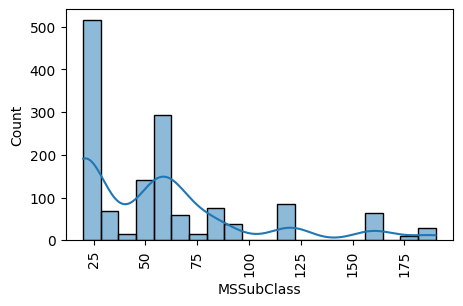

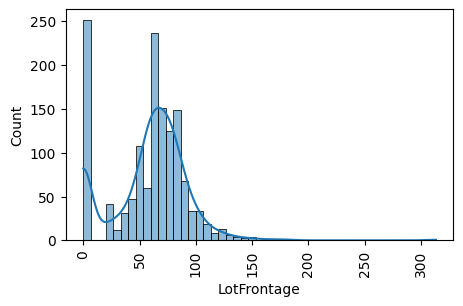

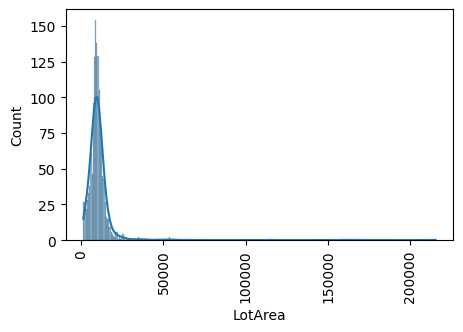

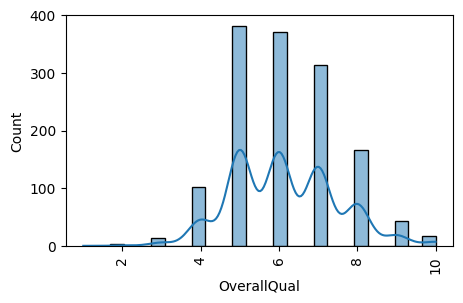

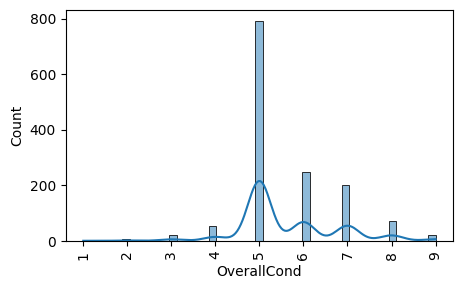

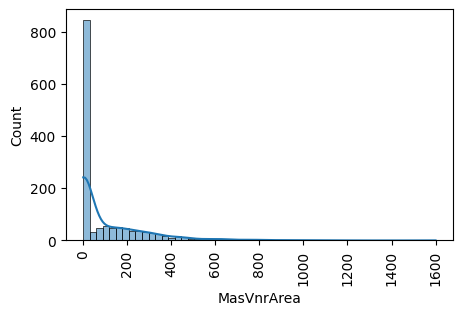

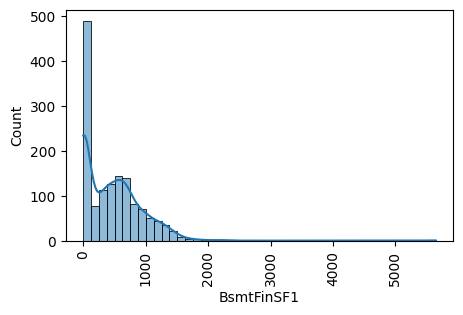

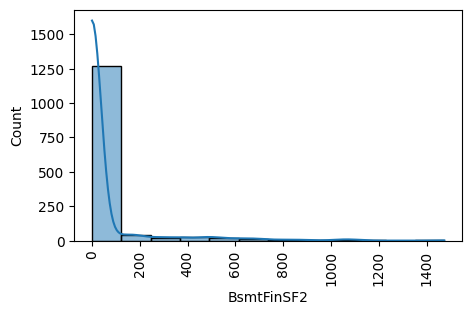

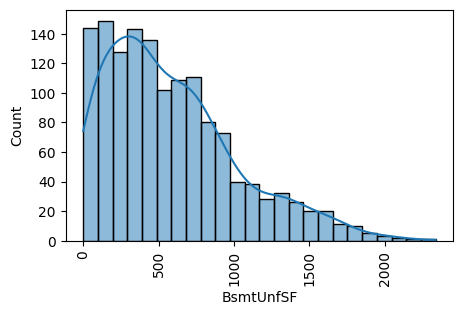

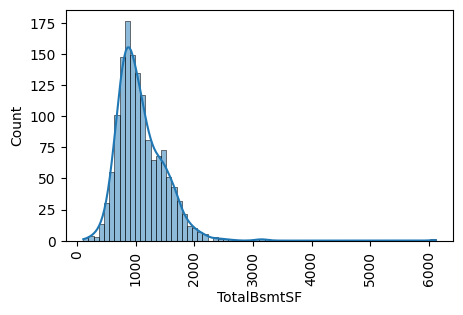

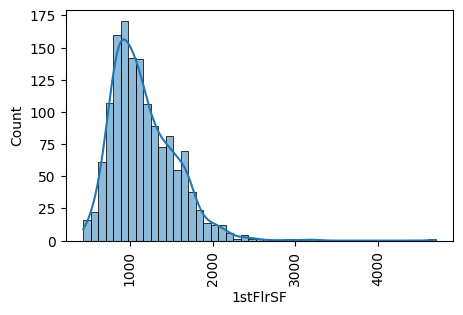

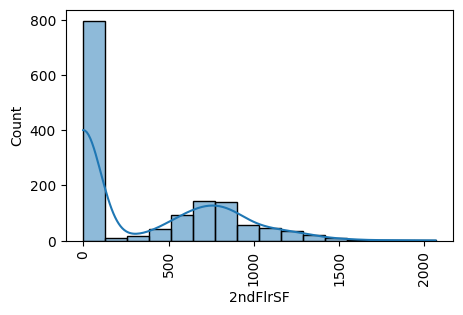

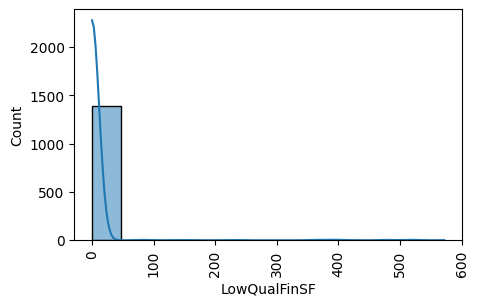

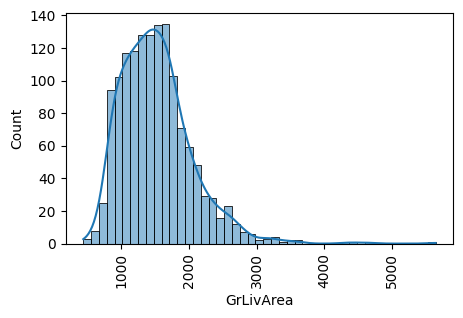

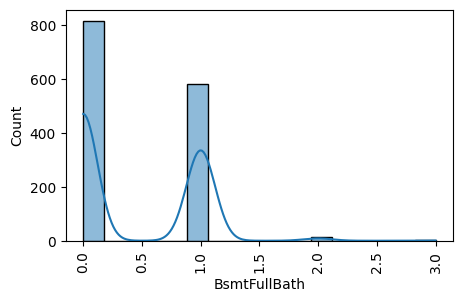

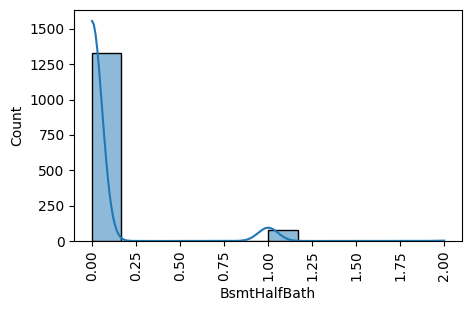

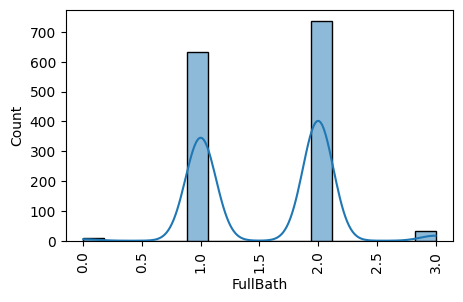

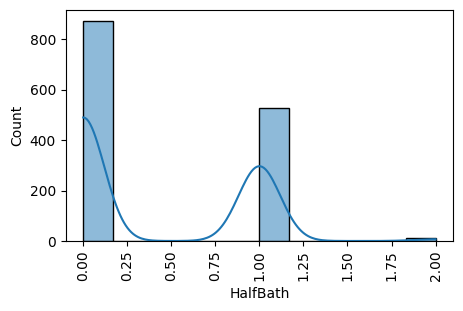

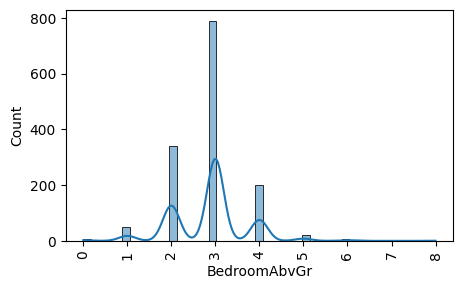

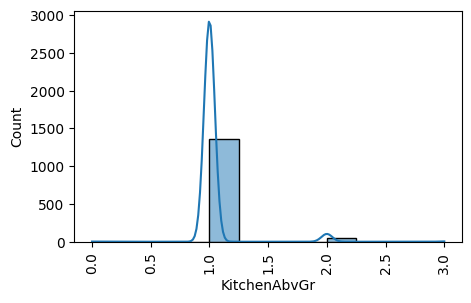

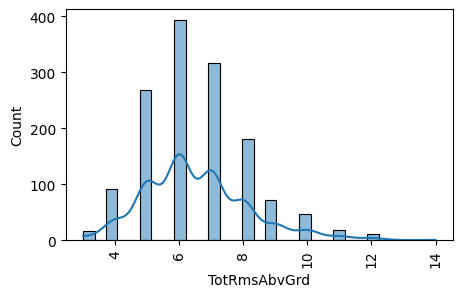

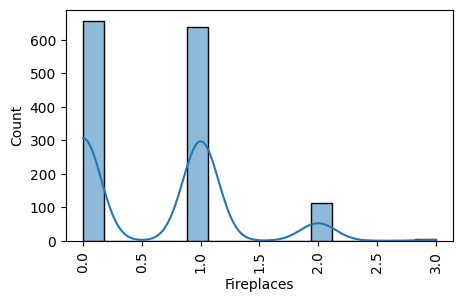

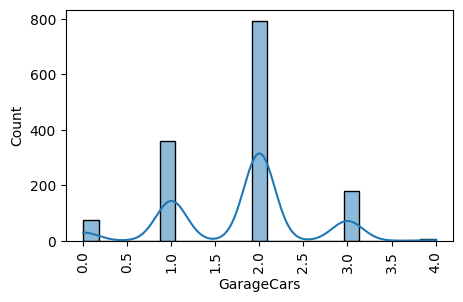

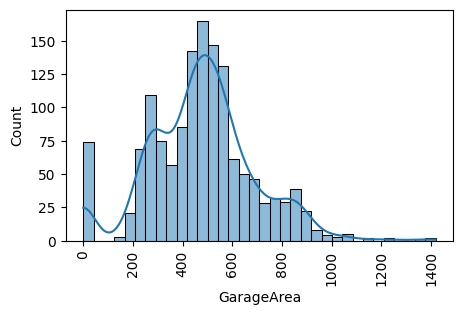

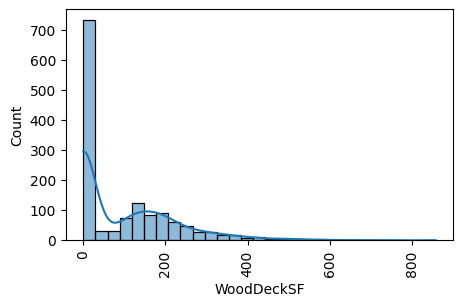

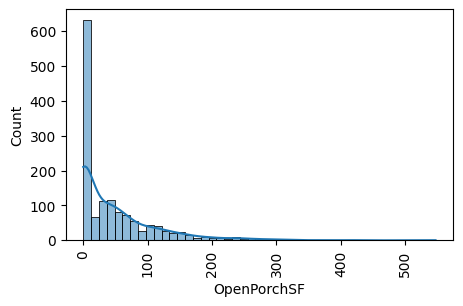

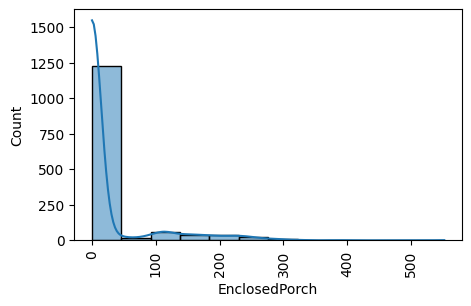

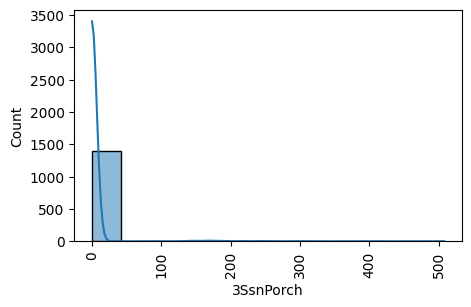

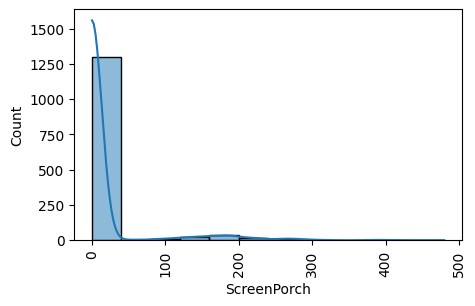

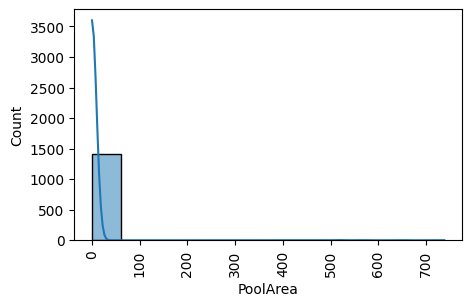

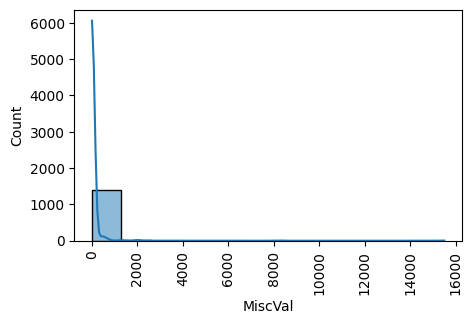

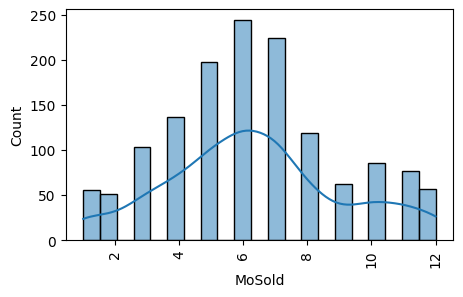

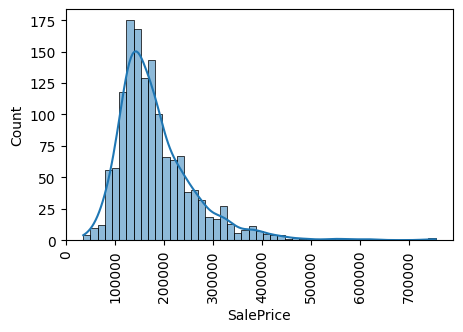

In [21]:
num_cols = [col for col in houseprice_train if (houseprice_train[col].dtype) in (['int64','float64'])]
for col in num_cols:
    plt.figure(figsize = (5,3))
    sns.histplot(data = houseprice_train, x = col, kde = True)
    plt.xticks(rotation=90)
    plt.show()
    

We can see that a lot of numerical columns have outliers. We will therefore fit two models where in one, all numerical columns have been scaled and in the other, the values are as they are.
Next we will do bivariate analysis on numerical columns. We will make use of the correlation matrix to achieve this;

In [22]:
houseprice_train[num_cols].corr().style.background_gradient(cmap='viridis')

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,SalePrice
MSSubClass,1.000000,-0.223152,-0.138298,0.038952,-0.063240,0.023024,-0.067783,-0.064875,-0.139572,-0.253332,-0.254277,0.306522,0.047349,0.073167,0.007005,-0.002111,0.121525,0.181273,-0.031432,0.266075,0.030657,-0.040128,-0.034897,-0.094523,-0.014568,-0.005684,-0.016768,-0.041226,-0.026202,0.008496,-0.022705,-0.016463,-0.082281
LotFrontage,-0.223152,1.000000,0.103032,0.173469,-0.056066,0.106525,0.078014,-0.011484,0.160667,0.256820,0.250895,0.043482,0.051637,0.224452,0.010952,-0.028523,0.123113,-0.014987,0.149448,0.038418,0.225722,0.048464,0.166745,0.203917,-0.014973,0.067004,0.030130,0.023604,0.022866,0.115250,-0.060771,0.010463,0.210319
LotArea,-0.138298,0.103032,1.000000,0.104763,-0.002941,0.104010,0.213450,0.111381,-0.008757,0.275637,0.296342,0.052246,0.004237,0.260524,0.157024,0.047774,0.124752,0.013808,0.119153,-0.016379,0.189107,0.268960,0.153812,0.180207,0.172281,0.083860,-0.022978,0.021153,0.042818,0.077814,0.041567,0.001070,0.264803
OverallQual,0.038952,0.173469,0.104763,1.000000,-0.121155,0.409656,0.211652,-0.072897,0.278239,0.509473,0.486418,0.291858,-0.034460,0.594985,0.082932,-0.048771,0.576543,0.256616,0.096722,-0.145423,0.438254,0.392978,0.607663,0.561612,0.230274,0.297678,-0.122678,0.032014,0.059290,0.065474,-0.025344,0.064301,0.786765
OverallCond,-0.063240,-0.056066,-0.002941,-0.121155,1.000000,-0.134961,-0.057034,0.036885,-0.159769,-0.221992,-0.145056,0.022496,0.023482,-0.085187,-0.064559,0.115694,-0.190209,-0.072977,0.016070,-0.062543,-0.058852,-0.030047,-0.193904,-0.163341,-0.013206,-0.041823,0.075663,0.022557,0.050897,-0.003298,0.070685,-0.008530,-0.093567
MasVnrArea,0.023024,0.106525,0.104010,0.409656,-0.134961,1.000000,0.259291,-0.077978,0.103094,0.371677,0.348471,0.170468,-0.070279,0.389884,0.077607,0.024618,0.277278,0.197999,0.101925,-0.024685,0.283266,0.241914,0.363992,0.370982,0.157566,0.124018,-0.116271,0.018240,0.059422,0.011161,-0.027143,-0.009909,0.474525
BsmtFinSF1,-0.067783,0.078014,0.213450,0.211652,-0.057034,0.259291,1.000000,-0.060807,-0.551475,0.504307,0.449253,-0.146842,-0.067677,0.200188,0.639301,0.063313,0.060432,-0.015215,-0.110303,-0.047761,0.043425,0.250394,0.215661,0.288913,0.196236,0.098352,-0.109122,0.028958,0.057169,0.141557,0.009120,-0.020850,0.368849
BsmtFinSF2,-0.064875,-0.011484,0.111381,-0.072897,0.036885,-0.077978,-0.060807,1.000000,-0.229907,0.086766,0.096786,-0.102037,0.014164,-0.012671,0.153697,0.069425,-0.077119,-0.035756,-0.016933,-0.030390,-0.037115,0.042980,-0.045063,-0.025604,0.065614,0.002020,0.037693,-0.030142,0.087231,0.041342,0.006542,-0.018511,-0.020196
BsmtUnfSF,-0.139572,0.160667,-0.008757,0.278239,-0.159769,0.103094,-0.551475,-0.229907,1.000000,0.367804,0.323319,-0.005837,0.026082,0.234042,-0.466741,-0.106229,0.301666,-0.065741,0.171986,0.101544,0.258237,0.034840,0.204255,0.170188,-0.022720,0.118343,-0.003900,0.023565,-0.021628,-0.038245,-0.017937,0.031132,0.188959
TotalBsmtSF,-0.253332,0.256820,0.275637,0.509473,-0.221992,0.371677,0.504307,0.086766,0.367804,1.000000,0.894018,-0.212704,-0.042224,0.473111,0.276712,-0.015582,0.362967,-0.102622,0.054995,0.043773,0.313035,0.336714,0.445240,0.498678,0.222698,0.239398,-0.111764,0.045885,0.076152,0.134601,-0.006489,0.002725,0.611084


## Data Preprocessing
### Checking categorical variables

How many unique categories are there in each categorical variable?


In [23]:
unique_counts = {col: houseprice_train[col].nunique() for col in houseprice_train if houseprice_train[col].dtype == 'object'}

# Convert the dictionary to a DataFrame
unique_counts_df = pd.DataFrame.from_dict(unique_counts, orient='index', columns=['unique_values']).reset_index()

# Rename columns for clarity
unique_counts_df = unique_counts_df.rename(columns={'index': 'column_name'})

display(unique_counts_df)
cat_columns = [col for col in houseprice_train.columns if houseprice_train[col].dtype == 'object']
print(cat_columns)

,column_name,unique_values
0,MSZoning,5
1,Street,2
2,LotShape,4
3,LandContour,4
4,Utilities,2
5,LotConfig,5
6,LandSlope,3
7,Neighborhood,25
8,Condition1,9
9,Condition2,8


['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition']


There are some categorical variables with many unique values. It is clear however that most of our categorical variables have less than 10 unique values.
Next we will do one hot encoding of all these columns.

In [24]:
houseprice_train_cat = houseprice_train[cat_columns]
houseprice_train_cat = pd.get_dummies(houseprice_train_cat, drop_first = True)
houseprice_train_cat.shape

(1412, 193)

In [25]:
houseprice_train_num = houseprice_train[num_cols]
houseprice_train_num.shape
houseprice_train_df = pd.concat([houseprice_train_num, houseprice_train_cat], axis = 1)
houseprice_train_df.shape

(1412, 226)

# Model fitting

### Linear regression

In [26]:
X = houseprice_train_df.drop(columns = ['SalePrice'], axis = 1)
y = houseprice_train_df['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
linreg = LinearRegression()
linreg.fit(X_train, y_train)

LinearRegression()

In [27]:
base_score = linreg.score(X_test, y_test)
base_score

0.7525298651892284

### Regularized regression

### Feature selection using lasso regression

In [28]:
from sklearn.linear_model import Lasso, Ridge
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score, KFold
lasso = Lasso(alpha = 100)
lasso.fit(X,y)
lasso = SelectFromModel(lasso, prefit=True)
selected_features = X.columns[lasso.get_support()]
selected_features = selected_features [:100]

In [29]:
new_X = houseprice_train_df[selected_features]
X_train, X_test, y_train, y_test = train_test_split(new_X, y, test_size = 0.3, random_state = 42)
kf = KFold(n_splits = 10, shuffle = True, random_state = 42)
lr = LinearRegression()
ridge = Ridge(42)
cv_results = cross_val_score(lr,X_train, y_train, cv = kf)
print(cv_results.mean())
lr.fit(X_train, y_train)
ridge.fit(X_train, y_train)
score = lr.score(X_test, y_test)
score1 = ridge.score(X_test, y_test)
print(score, score1)

0.8455904993610579
0.7678418435778223 0.739974646304516
